# XGBoost model

In [1]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline

import modify_dataset as md

In [2]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


In [3]:
df = pd.read_csv("dataset/preprocessed_train_PCA.csv")

In [4]:
df = df.drop(['NumberOfCustomers'], axis=1)
#df = df.drop(['Region','Events'], axis=1)
# I could leave events

In [5]:
df.shape

(433958, 48)

In [6]:
#for now let's drop unusable categorical vars
df = df.drop(['StoreType','AssortmentType','Events'], axis=1)

In [7]:
#only for pca
df = df.drop(['Unnamed: 0'], axis=1)

In [8]:
df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
StoreID,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Date,01/03/2016,02/03/2016,04/03/2016,05/03/2016,07/03/2016,08/03/2016,09/03/2016,10/03/2016,11/03/2016,12/03/2016,14/03/2016,15/03/2016,16/03/2016,17/03/2016,18/03/2016,19/03/2016,21/03/2016,22/03/2016,23/03/2016,24/03/2016
IsHoliday,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
HasPromotions,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1
NearestCompetitor,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326
Region,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
NumberOfSales,5676,8111,8300,7154,10110,9019,8804,7823,7989,5895,6348,4738,6014,6087,6962,6618,9183,8155,7109,8041
Region_AreaKM2,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643,9643
Region_GDP,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130,17130
Region_PopulationK,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770,2770


In [9]:
df.shape

(433958, 44)

In [10]:
train = md.get_fake_train(df)

In [11]:
train.shape

(397047, 44)

In [12]:
test = md.get_fake_test(df)
test.shape

(36911, 44)

In [13]:
#print("Load the training, test and store data using pandas")
#train = pd.read_csv("train.csv",low_memory=False)
#test = pd.read_csv("test.csv")
#store = pd.read_csv("store.csv")

### Selecting predictive features 

In [14]:
from pprint import pprint
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
#features.remove('Region')
#features.remove('Region_GDP')
#features.remove('Max_Dew_PointC')
#features.remove('Min_Sea_Level_PressurehPa')
#features.remove('Precipitationmm')
#features.remove('Mean_Dew_PointC')
#features.remove('Min_TemperatureC')
#features.remove('p11')
#features.remove('p4')
features.remove('D_DayOfweek')
features.remove('Date')
print("features")

pprint(features)

features
['IsHoliday',
 'HasPromotions',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'CloudCover',
 'Max_VisibilityKm',
 'Min_VisibilitykM',
 'WindDirDegrees',
 'D_Day',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'StoreType_SuperMarket',
 'StoreType_HyperMarket',
 'StoreType_StandardMarket',
 'StoreType_ShoppingCenter',
 'AssortmentType_General',
 'AssortmentType_WithNFDept',
 'AssortmentType_WithFishDept',
 'MeanStoreSales',
 'MeanRegionSales',
 'MeanCustomers',
 'MeanRegionCustomers',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 'p10',
 'p11',
 'p12']


In [15]:
features.remove('p11')
features.remove('p12')
features.remove('p7')
features.remove('p9')

features.remove('p8')
features.remove('p4')

In [16]:
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 8,
          "subsample": 1.0,
          "colsample_bytree": 0.3, #0.3
          "silent": 1,
          "nthread":-1,
          #added as a test
          "eval_metric": "rmse",
          #"gamma": 2  #added as a test
          "seed": 23
          }

#reg_alpha 
#reg_lambda
num_trees = 100 #400

In [17]:
#split in train and test (not real test which is called test and is the fake test provided by md)
X_train, X_test = train_test_split(train, test_size=0.05)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [18]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [19]:
X_train.shape

(377194, 44)

In [20]:
X_test.shape

(19853, 44)

In [21]:
#watchlist = [(dvalid, 'test'), (dtrain, 'train')]
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

In [22]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

[0]	test-rmse:6.33448	train-rmse:6.33638
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[1]	test-rmse:5.07235	train-rmse:5.07389
[2]	test-rmse:4.06368	train-rmse:4.06529
[3]	test-rmse:3.25762	train-rmse:3.25926
[4]	test-rmse:2.61048	train-rmse:2.612
[5]	test-rmse:2.09404	train-rmse:2.09565
[6]	test-rmse:1.68031	train-rmse:1.68137
[7]	test-rmse:1.35182	train-rmse:1.35264
[8]	test-rmse:1.0908	train-rmse:1.0911
[9]	test-rmse:0.880577	train-rmse:0.880571
[10]	test-rmse:0.715927	train-rmse:0.715398
[11]	test-rmse:0.583602	train-rmse:0.582494
[12]	test-rmse:0.48108	train-rmse:0.479219
[13]	test-rmse:0.402552	train-rmse:0.399895
[14]	test-rmse:0.341197	train-rmse:0.337412
[15]	test-rmse:0.29616	train-rmse:0.290958
[16]	test-rmse:0.26275	train-rmse:0.256464
[17]	test-rmse:0.239363	train-rmse:0.23195
[18]	test-rmse:0.22059	train-rmse:0.212215
[19]	test-rmse:0.204512	train-rmse:0.19515
[20]	test-rms

### Validating

In [23]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.5086876988046841


RMSE

In [24]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

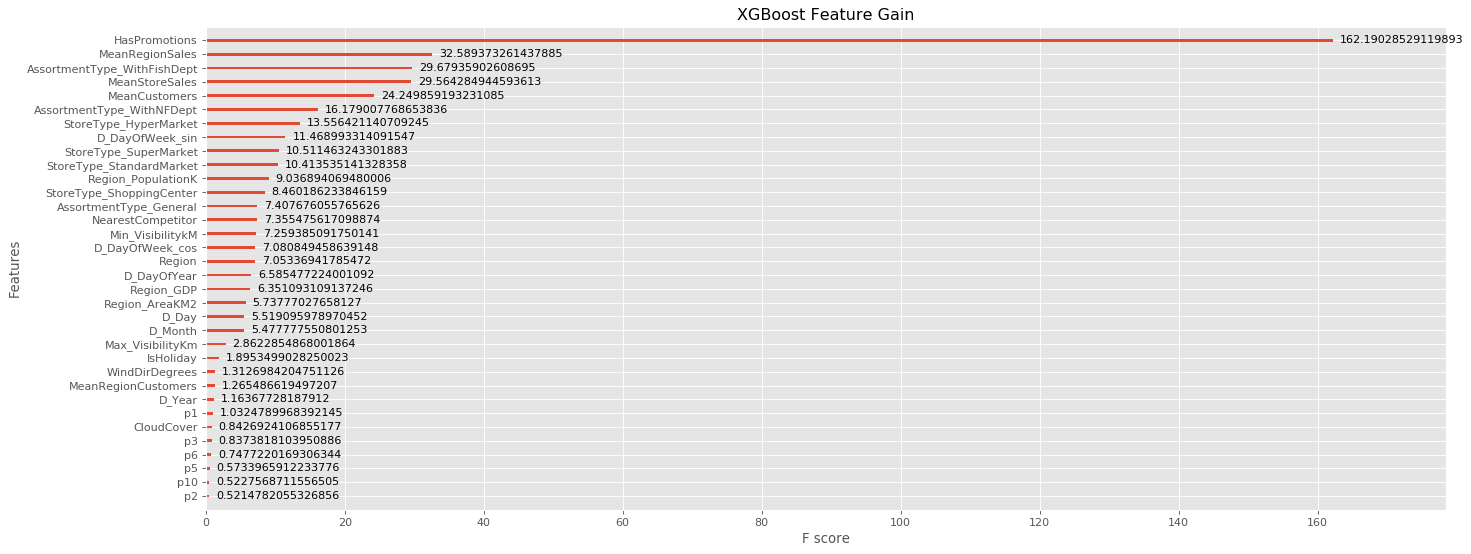

In [25]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

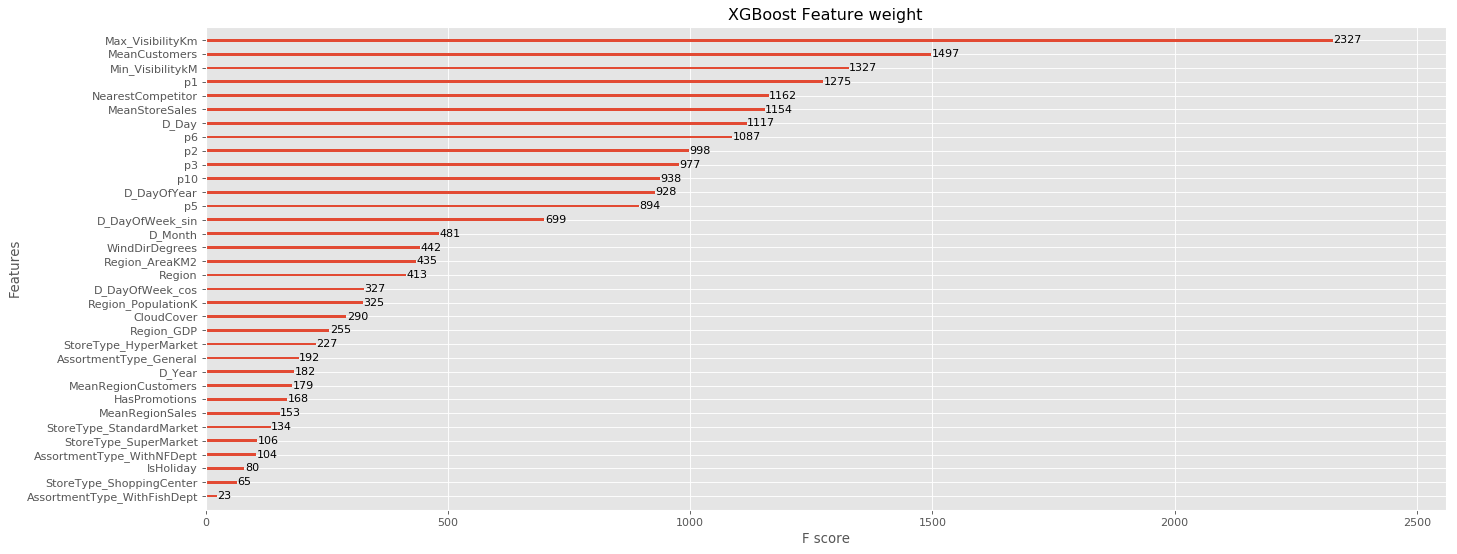

In [26]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

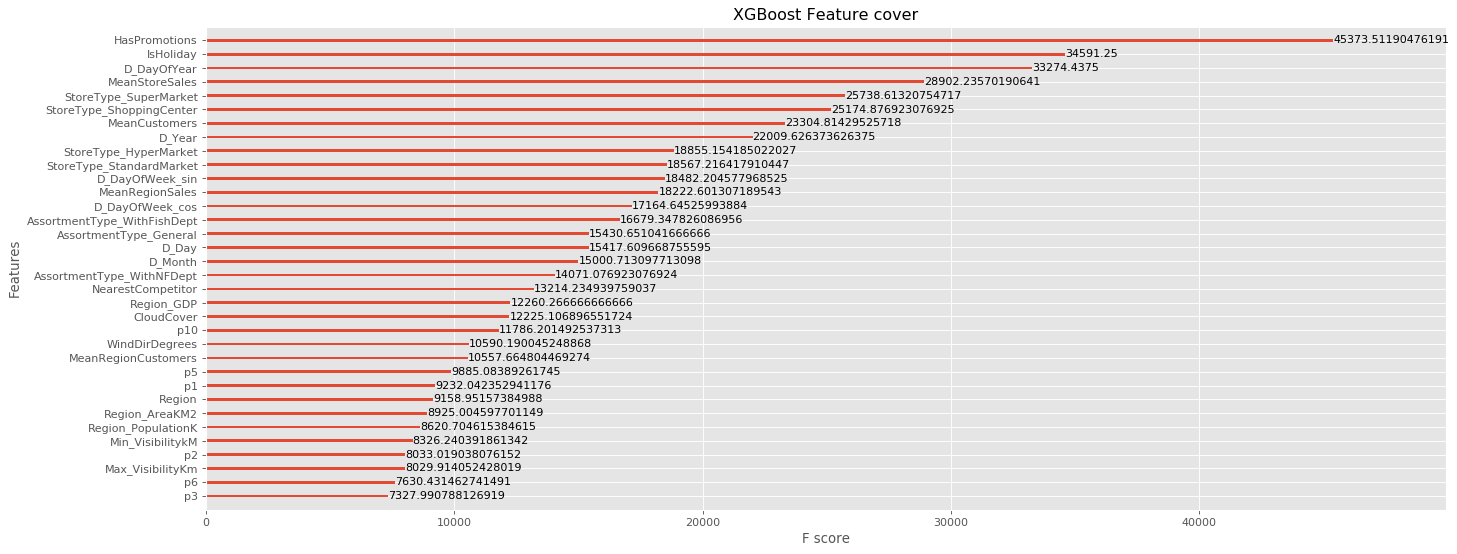

In [27]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [28]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [29]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

C:\Users\Mirko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

In [30]:
from BIP import get_BIP_error

In [31]:
error1 = get_BIP_error(test)

Number of regions identified: 11
BIP total error: 0.04823546135262982


In [32]:
diff=test['NumberOfSales']-test['_NumberOfSales']

In [33]:
diff.head(15).T

548     586.030273
549    1997.158203
550     -75.381348
551    -581.808105
552   -1207.777344
553   -1133.689453
554    -955.699219
555   -1137.860352
556   -1860.183105
557    -699.881836
558   -1018.382324
559     379.275391
560     934.741211
561    -107.824219
562    -440.408203
dtype: float32

In [34]:
diff.mean()

50.17041778564453

In [35]:
train_probs.shape

(36911,)

In [36]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [37]:
compare = test[['NumberOfSales','_NumberOfSales']]

### Saving TEST

In [38]:
#test.to_csv('./dataset/XGB5_fake_test.csv', index=False)

In [39]:
error = rmspe(test['_NumberOfSales'].values, test['NumberOfSales'].values)
print('error', error)

error 0.20124750716394926


In [40]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
12243,5468,6061.601074
12244,6795,6302.151855
12245,7035,6610.198730
12246,5437,5731.373047
12247,5725,5324.344238
12248,5143,5382.803223
12249,5589,5502.188477
12250,7520,5643.157715
12251,3927,5002.704590
12252,3682,4197.215820


In [41]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
12243,5468,6061.601074
12244,6795,6302.151855
12245,7035,6610.198730
12246,5437,5731.373047
12247,5725,5324.344238
12248,5143,5382.803223
12249,5589,5502.188477
12250,7520,5643.157715
12251,3927,5002.704590
12252,3682,4197.215820


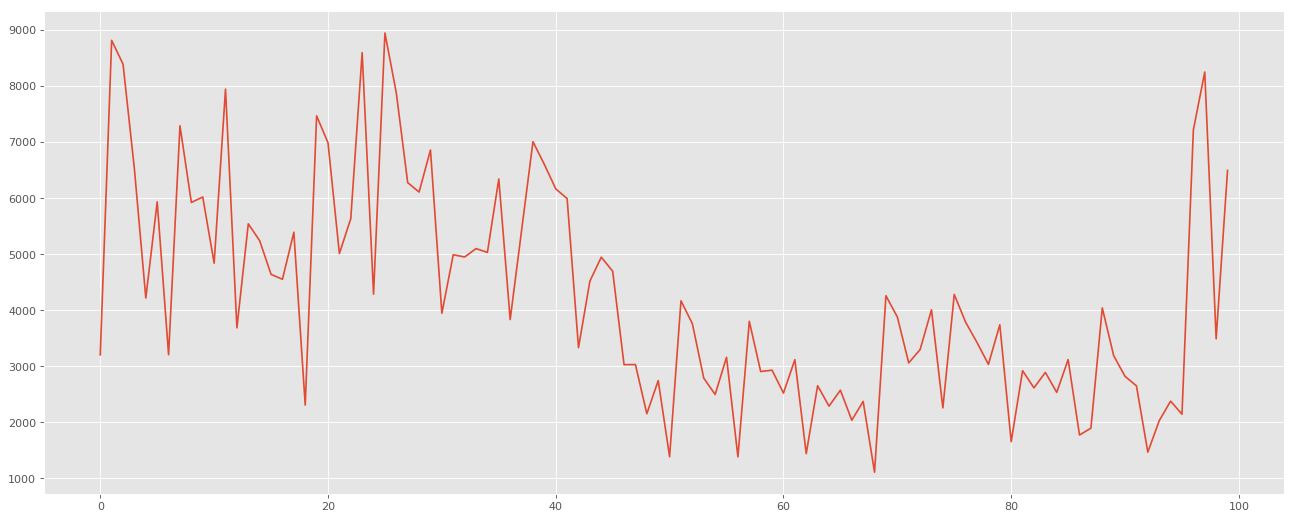

In [42]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

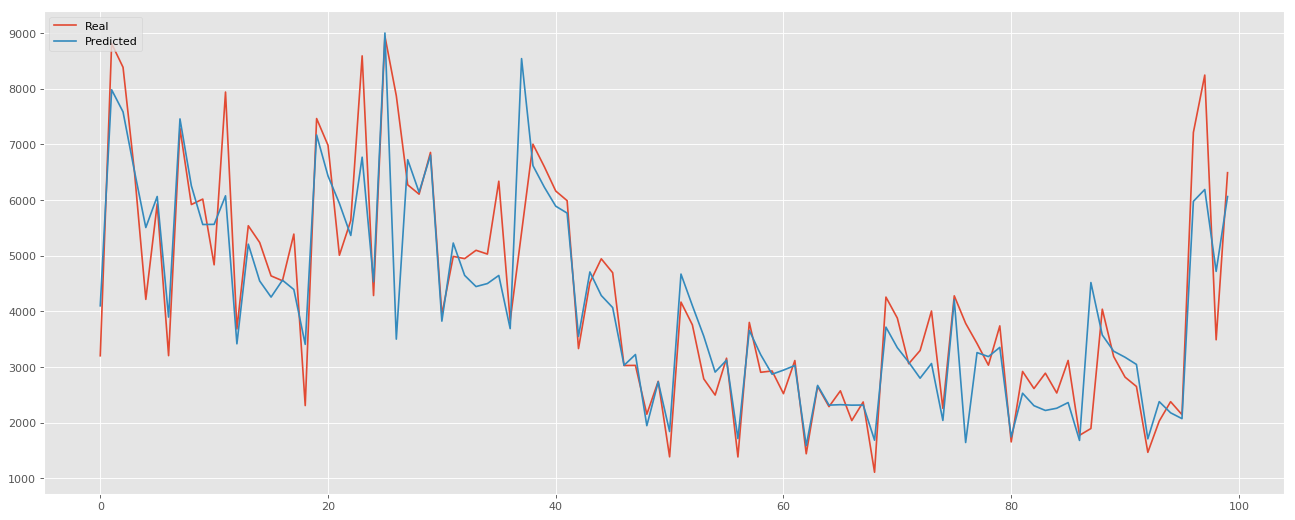

In [43]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

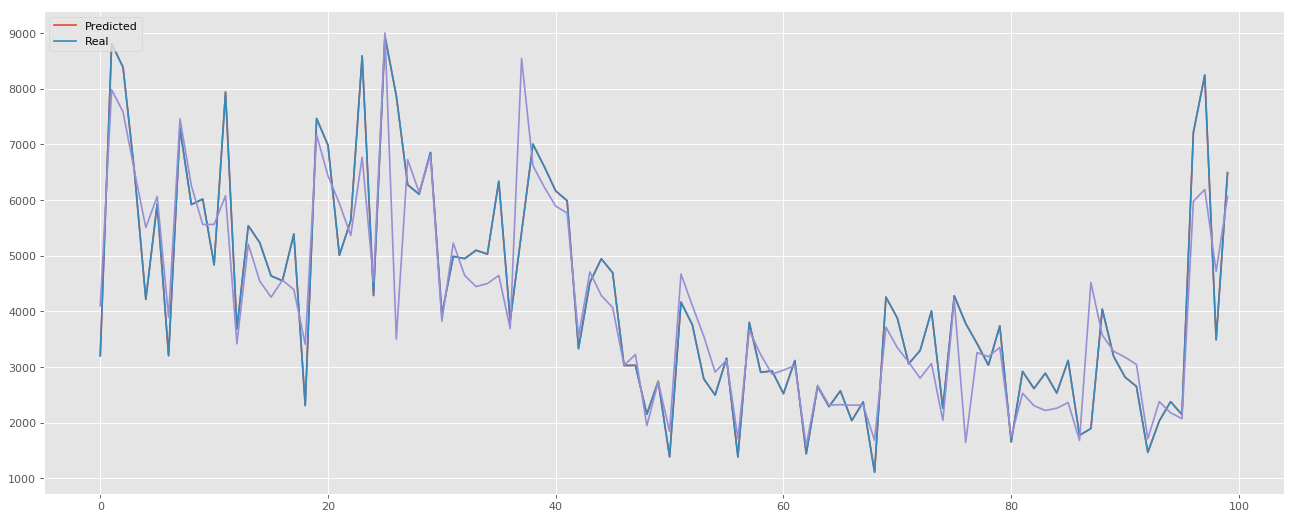

In [44]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [45]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

ValueError: operands could not be broadcast together with shapes (19853,) (36911,) 

In [ ]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

In [ ]:
Y = df.iloc[:, 3]

In [ ]:
Y